In [1]:
import datajoint as dj

In [2]:
dj.config['database.host'] = '127.0.0.1'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'tut'

In [3]:
dj.conn()

Connecting root@127.0.0.1:3306


DataJoint connection (connected) root@127.0.0.1:3306

In [4]:
schema = dj.schema('celia', locals())
# schema = dj.schema(dj.config['custom'].get('database.prefix', '') + 'reference')

In [5]:
### ### ### ###
### subject ###
### ### ### ###

In [6]:
@schema
class Strain(dj.Lookup):
    definition = """
    Strain: varchar(24)
    """
    contents = zip(['tests'])

@schema
class Allele(dj.Lookup):
    definition = """
    allele: varchar(24)
    """
    contents = zip(['testa'])

@schema
class Hemisphere(dj.Lookup):
    definition = """
    hemisphere: varchar(16)
    """
    contents = zip(['left', 'right', 'bilateral'])

@schema
class BrainLocation(dj.Lookup):
    definition = """
    brain_region: varchar(32)
    brain_subregion = 'N/A': varchar(32)
    -> Hemisphere
    ---
    brain_location_full_name = 'N/A': varchar(128)
    """
    
@schema
class OpticFiber(dj.Lookup):
    definition = """
    fiber_name: varchar(32)
    #channel_counts: smallint
    #---
    #probe_type = "": varchar(32)
    #probe_desc = "": varchar(1024)
    """
    
    class VoltageSource(dj.Part):
        definition = """
        -> master
        voltage_id: smallint
        """
    
    class PhotoDetector(dj.Part):
        definition = """
        -> master
        detector_id: smallint
        ---
        -> OpticFiber.VoltageSource
        """

        
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id: int # unique mouse identifier
    ---
    dob: date # date of birth
    -> Strain
    """
    
    class Allele(dj.Part):
        definition = """
        -> master
        -> Allele
        """

@schema
class FiberInsertion(dj.Manual):
    definition = """
    -> Mouse
    -> OpticFiber
    -> BrainLocation
    insertion_depth: decimal(6,2)
    """

@schema
class ExperimentType(dj.Lookup):
    #task: varchar(32)
    definition = """
    experiment_type: varchar(32)
    """
    
#     contents = zip([['headfixed', 'freelymoving'],['lick']])
    contents = zip(['headfixed', 'freelymoving'])

@schema
class RecordingTechnique(dj.Lookup):
    definition = """
    rec_technique: varchar(32)
    """
    
    contents = zip(['photometry', 'ca2'])

@schema
class Session(dj.Manual):
    definition = """
    -> Mouse
    session_time: datetime
    session_id: smallint
    ---
    session_directory = "": varchar(256)
    session_note = "": varchar(256)
    -> ExperimentType
    -> RecordingTechnique
    """

@schema
class TrialType(dj.Manual):
    definition = """
    left_likelihood: int
    right_likelihood: int
    """
    
@schema
class TrialResponse(dj.Lookup):
    definition = """
    response_action: varchar(32)
    """
    contents = zip(['correct', 'incorrect', 'no action', 'early lick', 'N/A'])

@schema
class ExperimentalEvent(dj.Lookup):
    definition = """
    event_type: varchar(32)
    """
    contents = zip(['event_typea', 'event_typeb', 'event_typec'])
    
@schema
class TrialSet(dj.Manual):
    definition = """
    -> Session
    ---
    trial_counts: int
    """
    
    class Trial(dj.Part):
        definition = """
        -> master
        -> TrialResponse
        trial_id: smallint
        ---
        start_time = null: float
        -> TrialType
        trial_stim_present: bool
        trial_is_good: bool
        """
    
    class EventTime(dj.Part):
#         -> ExperimentalEvent.proj(trial_event="event")
        definition = """
        -> master.Trial
        ---
        event_time = null: float
        """

@schema
class PhotoDetectorRecord(dj.Manual):
    definition = """
    -> Session
    -> OpticFiber.PhotoDetector
    """
    

@schema
class TrialSegmentationSetting(dj.Lookup):
    definition = """
    trial_segmentation_basis_id: smallint
    ---
    -> ExperimentalEvent
    pre_stim_duration: decimal(6,4)  # (s) pre-stimulus duration # example entry from Economo
    post_stim_duration: decimal(6,4)  # (s) post-stimulus duration # example entry from Economo
    """
    contents = [[0, 'event_typea', 3.3975, 2.9975]]


@schema
class TrialSegmentedPhotoDetection(dj.Computed):
    definition = """
    -> PhotoDetectorRecord
    -> TrialSet.Trial
    -> TrialSegmentationSetting
    
    """

@schema
class RealignedEvent(dj.Computed):
    definition = """
    -> TrialSet.Trial
    -> TrialSegmentationSetting
    
    """
    
    class RealignedEventTime(dj.Part):
        definition = """
        -> master
        -> TrialSet.EventTime
        ---
        realigned_event_time = null: float
        """


In [7]:
# species = Species()
# allele = Allele()
# mouse = Mouse()


species = Strain()
allele = Allele()
hemisphere = Hemisphere()
brainlocation = BrainLocation()
opticfiber = OpticFiber()
fiberinsertion = FiberInsertion()
mouse = Mouse()

experimenttype = ExperimentType()
recordingtechnique = RecordingTechnique()

session = Session()
trial = TrialSet()
trialtype = TrialType()


trialresponse = TrialResponse()
experimentalevent = ExperimentalEvent()
trialset = TrialSet()
trial = TrialSet.Trial()
eventtime = TrialSet.EventTime()
photodetectorrecord = PhotoDetectorRecord()
trialsegmentationsetting = TrialSegmentationSetting()
trialsegmentedphotodetection = TrialSegmentedPhotoDetection()
realignedevent = RealignedEvent()
realignedeventtime = RealignedEvent.RealignedEventTime()

In [8]:
# mouse.insert1((1, '2019-08-01', 'tests'))
# brainlocation.insert1(('Striatum', 'N/A', 'left', 'lstr'))
# probeinsertion.insert1((1, 'probea', 4, 'Striatum', 'N/A', 'left', 5))
# trialtype.insert([(90,10),(80,20),(20,80),(10,90)])


# # probe.insert1(('probea', 4, '', ''))
# # mallele.insert1((1, 'testa'))

In [9]:
print('species:')
display(species)
print('allele:')
display(allele)
print('hemisphere:')
display(hemisphere)
print('brainlocation:')
display(brainlocation)
print('opticfiber:')
display(opticfiber)
print('fiberinsertion:')
display(fiberinsertion)
print('mouse:')
display(mouse)

print('experimenttype:')
display(experimenttype)
print('recordingtechnique:')
display(recordingtechnique)


print('session:')
display(session)
print('trial:')
display(trial)
print('trialtype:')
display(trialtype)

species:


species
tests


allele:


allele
testa


hemisphere:


hemisphere
bilateral
left
right


brainlocation:


brain_region,brain_subregion,hemisphere,brain_location_full_name


opticfiber:


fiber_name


fiberinsertion:


mouse_id unique mouse identifier,fiber_name,brain_region,brain_subregion,hemisphere,insertion_depth


mouse:


mouse_id unique mouse identifier,dob date of birth,species


experimenttype:


experiment_type
freelymoving
headfixed


recordingtechnique:


rec_technique
ca2
photometry


session:


mouse_id unique mouse identifier,session_time,session_id,session_directory,session_note,experiment_type,rec_technique


trial:


mouse_id unique mouse identifier,session_time,session_id,response_action,trial_id,start_time,left_likelihood,right_likelihood,trial_stim_present,trial_is_good


trialtype:


left_likelihood,right_likelihood


In [10]:
# species.drop()
# allele.drop()
# hemisphere.drop()
# brainlocation.drop()
# probe.drop()
# probeinsertion.drop()
# mouse.drop()

# experimenttype.drop()
# recordingtechnique.drop()


# session.drop()
# trial.drop()
# trialtype.drop()

In [11]:
# species.drop()
# allele.drop()
# mouse.drop()

In [12]:
# mallele = mouse.Allele()
# mallele

In [13]:
# mallele

In [14]:
# ## ### ### ### ###
# ## acquisition ###
# ## ### ### ### ###
# class Session(dj.Manual):
    

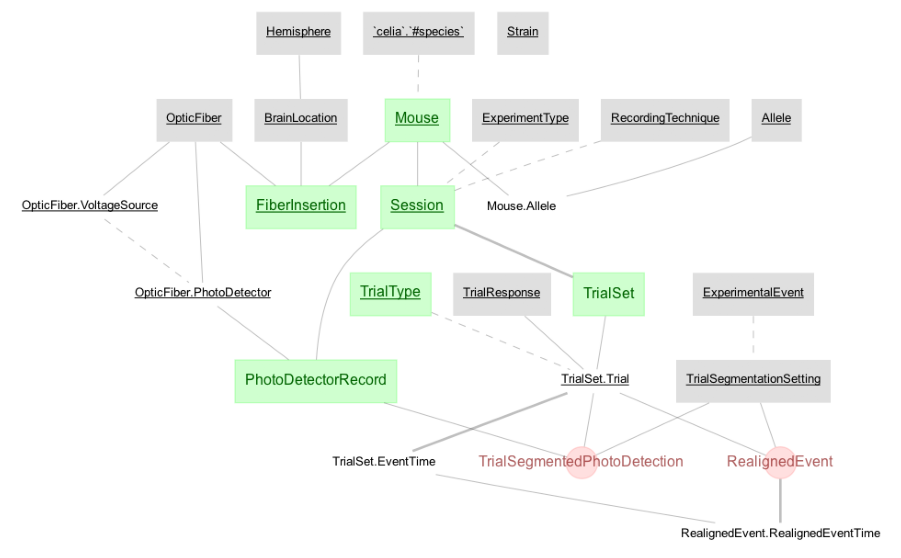

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
dj.ERD(schema).draw()

In [16]:
# Under session, analogue time series, then underneath that Trial Data
# Lynne: needs to use time series to derive the data

In [134]:
schema.drop()

Proceed to delete entire schema `celia`? [yes, No]: yes


In [135]:
schema = dj.schema('celia', locals())

@schema
class AnimalID(dj.Manual):
    definition = """
    animal_id: int # unique mouse identifier
    """

@schema
class AnimalInactive(dj.Manual):
    definition = """
    -> AnimalID
    """

@schema
class AnimalDetails(dj.Manual):
    definition = """
    -> AnimalID
    ---
    genotype: varchar(32)
    source: varchar(32)
    sex: varchar(1)
    dob: date # date of birth
    
    #surgery_info
    #exp_class: varchar(32)
    """


# @schema
# class Hemisphere(dj.Lookup):
#     definition = """
#     hemisphere: varchar(16)
#     """
#     contents = zip(['left', 'right', 'bilateral'])

# @schema
# class BrainLocation(dj.Lookup):
#     definition = """
#     brain_region: varchar(32)
#     brain_subregion = 'N/A': varchar(32)
#     -> Hemisphere
#     ---
#     brain_location_full_name = 'N/A': varchar(128)
#     """
    
# @schema
# class OpticFiber(dj.Lookup):
#     definition = """
#     fiber_name: varchar(32)
#     #channel_counts: smallint
#     #---
#     #probe_type = "": varchar(32)
#     #probe_desc = "": varchar(1024)
#     """
    
#     class VoltageSource(dj.Part):
#         definition = """
#         -> master
#         voltage_id: smallint
#         """
    
#     class PhotoDetector(dj.Part):
#         definition = """
#         -> master
#         detector_id: smallint
#         ---
#         -> OpticFiber.VoltageSource
#         """



# @schema
# class OpticFiber(dj.Lookup):
#     definition = """
#     fiber_name: varchar(32)
#     implant_type: varchar(32)
#     implant_site: varchar(32)
#     """
    

# @schema
# class FiberInsertion(dj.Manual):
#     definition = """
#     -> AnimalID
#     -> OpticFiber
#     -> BrainLocation
#     insertion_depth: decimal(6,2)
#     """

@schema
class FiberID(dj.Manual):
    definition = """
    -> AnimalID
    fiber_id: int
    """
    

@schema
class FiberSurgery(dj.Manual):
    definition = """
    -> FiberID
    ---
    fiber_name: varchar(32)
    implant_type: varchar(32)
    implant_site: varchar(32)
    
    virus: varchar(32)
    volume: float
    titer: varchar(32)
    injection_site: varchar(32)
    injection_date: date
    implant_date: date
    """

# @schema
# class ExperimentType(dj.Lookup):
#     #task: varchar(32)
#     definition = """
#     experiment_type: varchar(32)
#     """
    
# #     contents = zip([['headfixed', 'freelymoving'],['lick']])
#     contents = zip(['headfixed', 'freelymoving'])

# @schema
# class RecordingTechnique(dj.Lookup):
#     definition = """
#     rec_technique: varchar(32)
#     """
    
#     contents = zip(['photometry', 'ca2'])

@schema
class SessionID(dj.Manual):
    definition = """
    -> AnimalID
    session_id: smallint
    """

@schema
class SessionInactive(dj.Manual):
    definition = """
    -> SessionID
    """

@schema
class SessionDetails(dj.Manual):
    definition = """
    -> SessionID
    ---
    sesion_date: date
    session_time: time
    behavioral_conditions: varchar(256)
    neural_conditions: varchar(256)
    rec_technique = "photometry": varchar(32) # 'photometry'
    experiment_type: varchar(32) # 'headfixed' or 'freelymoving'
    session_note = "": varchar(256)
    
    #session_directory = "": varchar(256)
    #-> ExperimentType
    #-> RecordingTechnique
    """

@schema
class BehavioralTimeSeries(dj.Manual):
    definition = """
    -> SessionID
    ---
    behavioral_data: longblob
    """
    
    class TrialAligned(dj.Part):
        definition = """
        -> master
        ---
        aligned_behavioral_data: longblob
        """

@schema
class BehavioralEvents(dj.Manual):
    definition = """
    -> BehavioralTimeSeries.TrialAligned
    ---
    behavioral_events: longblob
    """
    
@schema
class PhotometryTimeSeries(dj.Manual):
    definition = """
    -> SessionID
    -> FiberSurgery
    ---
    photometry_data: longblob
    """

@schema
class TrialAlignedTimeSeries(dj.Manual):
    definition = """
    -> BehavioralTimeSeries.TrialAligned
    -> PhotometryTimeSeries
    ---
    aligned_behavioral_data: longblob
    aligned_phtometry_data: longblob
    """

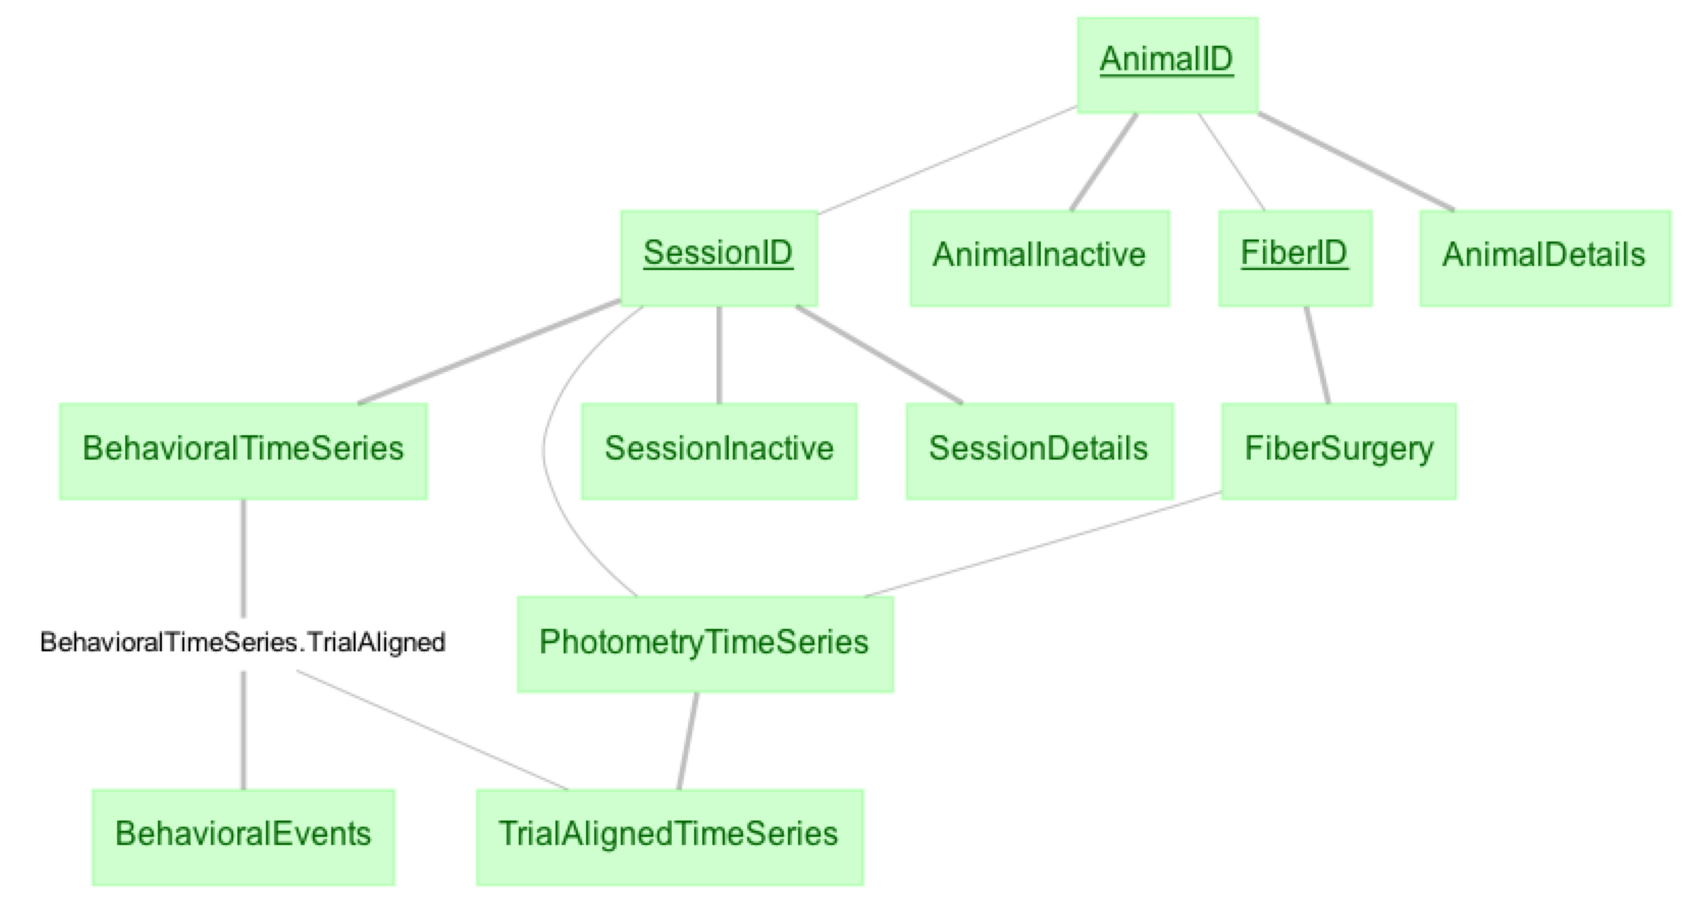

In [136]:

a = AnimalID()
b = AnimalDetails()

import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
dj.ERD(schema).draw()

In [ ]:
@schema
class Strain(dj.Lookup):
    definition = """
    species: varchar(24)
    """
    contents = zip(['tests'])

@schema
class Allele(dj.Lookup):
    definition = """
    allele: varchar(24)
    """
    contents = zip(['testa'])

@schema
class Hemisphere(dj.Lookup):
    definition = """
    hemisphere: varchar(16)
    """
    contents = zip(['left', 'right', 'bilateral'])

@schema
class BrainLocation(dj.Lookup):
    definition = """
    brain_region: varchar(32)
    brain_subregion = 'N/A': varchar(32)
    -> Hemisphere
    ---
    brain_location_full_name = 'N/A': varchar(128)
    """
    
@schema
class OpticFiber(dj.Lookup):
    definition = """
    fiber_name: varchar(32)
    #channel_counts: smallint
    #---
    #probe_type = "": varchar(32)
    #probe_desc = "": varchar(1024)
    """
    
    class VoltageSource(dj.Part):
        definition = """
        -> master
        voltage_id: smallint
        """
    
    class PhotoDetector(dj.Part):
        definition = """
        -> master
        detector_id: smallint
        ---
        -> OpticFiber.VoltageSource
        """

        
@schema
class Mouse(dj.Manual):
    definition = """
    mouse_id: int # unique mouse identifier
    ---
    dob: date # date of birth
    -> Strain
    """
    
    class Allele(dj.Part):
        definition = """
        -> master
        -> Allele
        """

@schema
class FiberInsertion(dj.Manual):
    definition = """
    -> Mouse
    -> OpticFiber
    -> BrainLocation
    insertion_depth: decimal(6,2)
    """

@schema
class ExperimentType(dj.Lookup):
    #task: varchar(32)
    definition = """
    experiment_type: varchar(32)
    """
    
#     contents = zip([['headfixed', 'freelymoving'],['lick']])
    contents = zip(['headfixed', 'freelymoving'])

@schema
class RecordingTechnique(dj.Lookup):
    definition = """
    rec_technique: varchar(32)
    """
    
    contents = zip(['photometry', 'ca2'])

@schema
class Session(dj.Manual):
    definition = """
    -> Mouse
    session_time: datetime
    session_id: smallint
    ---
    session_directory = "": varchar(256)
    session_note = "": varchar(256)
    -> ExperimentType
    -> RecordingTechnique
    """

@schema
class TrialType(dj.Manual):
    definition = """
    left_likelihood: int
    right_likelihood: int
    """
    
@schema
class TrialResponse(dj.Lookup):
    definition = """
    response_action: varchar(32)
    """
    contents = zip(['correct', 'incorrect', 'no action', 'early lick', 'N/A'])

@schema
class ExperimentalEvent(dj.Lookup):
    definition = """
    event_type: varchar(32)
    """
    contents = zip(['event_typea', 'event_typeb', 'event_typec'])
    
@schema
class TrialSet(dj.Manual):
    definition = """
    -> Session
    ---
    trial_counts: int
    """
    
    class Trial(dj.Part):
        definition = """
        -> master
        -> TrialResponse
        trial_id: smallint
        ---
        start_time = null: float
        -> TrialType
        trial_stim_present: bool
        trial_is_good: bool
        """
    
    class EventTime(dj.Part):
#         -> ExperimentalEvent.proj(trial_event="event")
        definition = """
        -> master.Trial
        ---
        event_time = null: float
        """

@schema
class PhotoDetectorRecord(dj.Manual):
    definition = """
    -> Session
    -> OpticFiber.PhotoDetector
    """
    

@schema
class TrialSegmentationSetting(dj.Lookup):
    definition = """
    trial_segmentation_basis_id: smallint
    ---
    -> ExperimentalEvent
    pre_stim_duration: decimal(6,4)  # (s) pre-stimulus duration # example entry from Economo
    post_stim_duration: decimal(6,4)  # (s) post-stimulus duration # example entry from Economo
    """
    contents = [[0, 'event_typea', 3.3975, 2.9975]]


@schema
class TrialSegmentedPhotoDetection(dj.Computed):
    definition = """
    -> PhotoDetectorRecord
    -> TrialSet.Trial
    -> TrialSegmentationSetting
    
    """

@schema
class RealignedEvent(dj.Computed):
    definition = """
    -> TrialSet.Trial
    -> TrialSegmentationSetting
    
    """
    
    class RealignedEventTime(dj.Part):
        definition = """
        -> master
        -> TrialSet.EventTime
        ---
        realigned_event_time = null: float
        """
